## Import

In [1]:
import os
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Helper Functions

In [2]:
def split_traj_dict(basepath):
    dict_trajlist = {}
    for csv_path in [os.path.join(basepath, 'enriched_trajs', 'safe'), os.path.join(basepath, 'enriched_trajs', 'unsafe')]:
        csv_files = [f for f in os.listdir(csv_path) if os.path.isfile(os.path.join(csv_path, f))]
        
        for i, filename in enumerate(csv_files):
            
            if i % 1000 == 0:
                print("Processing file", i, "out of", len(csv_files), "files")
            df = pd.read_csv(os.path.join(csv_path, filename))
            total_c = df['c'].sum().astype(int)
            if total_c in dict_trajlist:
                dict_trajlist[total_c].append(df)
            else:
                dict_trajlist[total_c] = [df]
    
    return dict_trajlist

In [3]:
def plot_traj_logscore_dist(dict_lst_trajs, domain, start_cum_c=0, end_cum_c=41):

    figure(figsize=(18, 4.5), dpi=80)
    
    plot_data, plot_x = [], []
    for i in range(start_cum_c, end_cum_c):
        if i in dict_lst_trajs:
            plot_data.append([np.exp(traj_df['new_logscore_mean'].sum()) for traj_df in dict_lst_trajs[i]])
            plot_x.append(i)
    
    # Create the boxplots
    plt.boxplot(plot_data, positions=plot_x, widths=0.8, patch_artist=True,
                boxprops=dict(facecolor='blue', alpha=0.6), tick_labels=plot_x, showmeans=True)
    
    #Customize x-axis positions
    #plt.xticks([(pos1 + pos2) / 2 for pos1, pos2 in zip(positions1, positions2)], x_labels)
    
    # Add grid and labels
    plt.title(domain, fontsize=18)
    plt.ylabel('Distribution - P(Safe Traj)', fontsize=16)
    plt.xlabel('Total Cost Incurred', fontsize=16)
    plt.xticks(fontsize=14)  # X-axis tick font size
    plt.yticks(fontsize=14)  # Y-axis tick font size
    plt.grid(axis='y')
    
    # Show the plot
    # plt.legend()
    plt.savefig(domain + '_safety_var_distribution.pdf')
    
    plt.show()

In [4]:
def plot_ratio_window_logscore(dict_lst_trajs, domain):
    dict_prop = {}
    bef_timesteps_tuple = [(-25, -20), (-20, -15), (-15, -10), (-10, -5), (-5, 0)]
    for timestep_tuple in bef_timesteps_tuple:
        dict_prop[timestep_tuple] = []
    aft_timesteps_tuple = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25)]
    for timestep_tuple in aft_timesteps_tuple:
        dict_prop[timestep_tuple] = []
    
    for cum_c, lst_df in dict_lst_trajs.items():
        if cum_c > 25:
            for df in lst_df:
                threshold_idx = df[(df['cum_c'] == 26) & (df['c'] == 1)].index[0]
                for timestep_bef_tuple in bef_timesteps_tuple:
                    start_idx, end_idx = threshold_idx + timestep_bef_tuple[0], threshold_idx + timestep_bef_tuple[1]
                    if start_idx >= 0 or end_idx > 0:
                        if start_idx < 0:
                            start_idx = 0
                        elif end_idx <= 0:
                            end_idx = 1
                            
                        dict_prop[timestep_bef_tuple].append(df[start_idx:end_idx]['new_logscore_mean'].mean() / df['new_logscore_mean'].mean())
                
                for timestep_aft_tuple in aft_timesteps_tuple:
                    start_idx, end_idx = threshold_idx + timestep_aft_tuple[0], threshold_idx + timestep_aft_tuple[1]
                    if start_idx < df.shape[0] or end_idx <= df.shape[0]:                    
                        if start_idx >= df.shape[0]:
                            start_idx = df.shape[0] - 1
                        elif end_idx > df.shape[0]:
                            end_idx = df.shape[0]
                        
                        dict_prop[timestep_aft_tuple].append(df[start_idx:end_idx]['new_logscore_mean'].mean() / df['new_logscore_mean'].mean())
    
    figure(figsize=(8, 4), dpi=80)

    x_labels = bef_timesteps_tuple + aft_timesteps_tuple
    
    plot_data = []
    for k in x_labels:
        plot_data.append(dict_prop[k])
    
    # Customization for the mean marker
    meanprops = {
        "marker": "D",           # Diamond shape
        "markerfacecolor": "green", # Red color
        "markeredgecolor": "black",
        "markersize": 10          # Larger size
    }
    
    # Create the boxplots
    plt.boxplot(plot_data, positions=list(range(len(x_labels))), widths=0.3, patch_artist=True,
                boxprops=dict(facecolor='blue', alpha=0.6), tick_labels=x_labels, showmeans=True, meanprops=meanprops)
    
    plt.ylim(0, 6.5)
    
    #Customize x-axis positions
    #plt.xticks([(pos1 + pos2) / 2 for pos1, pos2 in zip(positions1, positions2)], x_labels)
    
    # Add grid and labels
    plt.title(domain, fontsize=16)
    plt.ylabel('Ratio (Window Ave / Traj Ave)', fontsize=14)
    plt.xlabel('Window Positions', fontsize=14)
    plt.xticks(fontsize=10)  # X-axis tick font size
    plt.yticks(fontsize=12)  # Y-axis tick font size
    plt.grid(axis='y')
    
    # Show the plot
    plt.savefig(domain + '_ratio_window_average_logscore.pdf' )
    plt.show()

In [5]:
def calc_flat_ratio(dict_lst_trajs, min_cum_c=40, buffer_space=20, min_flat_length=100):
    list_flat_logscores = []
    for cum_c, lst_df in dict_lst_trajs.items():
        if cum_c > min_cum_c:
            for df in lst_df:
                df_ave_logscore = df['new_logscore_mean'].mean()
                filtered_df = df[df.c > 0][['c', 'cum_c', 'new_logscore_mean']]
                filtered_idx = [0] + filtered_df.index.tolist()
                filtered_cum_c = [0] + filtered_df.cum_c.astype(int).tolist()
        
                for j in range(len(filtered_idx)):
                    if j < len(filtered_idx) - 1:                        
                        len_flat_region = filtered_idx[j+1] - filtered_idx[j]
                        #buffer_space = math.ceil(len_flat_region * 0.2)
                        # buffer_space = 20
                        if len_flat_region >= min_flat_length:
                            # print(df[(filtered_idx[j]+buffer_space):(filtered_idx[j+1]-buffer_space)])
                            list_flat_logscores.append(df[(filtered_idx[j]+buffer_space):(filtered_idx[j+1]-buffer_space)]['new_logscore_mean'].mean() / df_ave_logscore)
                    else:                        
                        len_flat_region = df.shape[0] - filtered_idx[j]
                        #buffer_space = math.ceil(len_flat_region * 0.2)
                        # buffer_space = 20
                        if len_flat_region >= min_flat_length:
                            list_flat_logscores.append(df[(filtered_idx[j]+buffer_space):]['new_logscore_mean'].mean() / df_ave_logscore)
    # print(df_ave_logscore)
    return list_flat_logscores

## Ant Domain

In [11]:
base_path_ant = '/SSD2/siowmeng/icml25_results/save_traj/exp-x/PPOLagLearnedH_0-0_SafetyAntVelocity-v1/SafetyAntVelocity-v1---55fb775100c88b77dcb231fcd49be70fc21188a3f53dc001b075b74c83bb94f1/PPOLagLearnedH-{SafetyAntVelocity-v1}/seed-000-2025-02-06-08-14-43'
dict_traj_ant = split_traj_dict(base_path_ant)

Processing file 0 out of 5661 files
Processing file 1000 out of 5661 files
Processing file 2000 out of 5661 files
Processing file 3000 out of 5661 files
Processing file 4000 out of 5661 files
Processing file 5000 out of 5661 files
Processing file 0 out of 4339 files
Processing file 1000 out of 4339 files
Processing file 2000 out of 4339 files
Processing file 3000 out of 4339 files
Processing file 4000 out of 4339 files


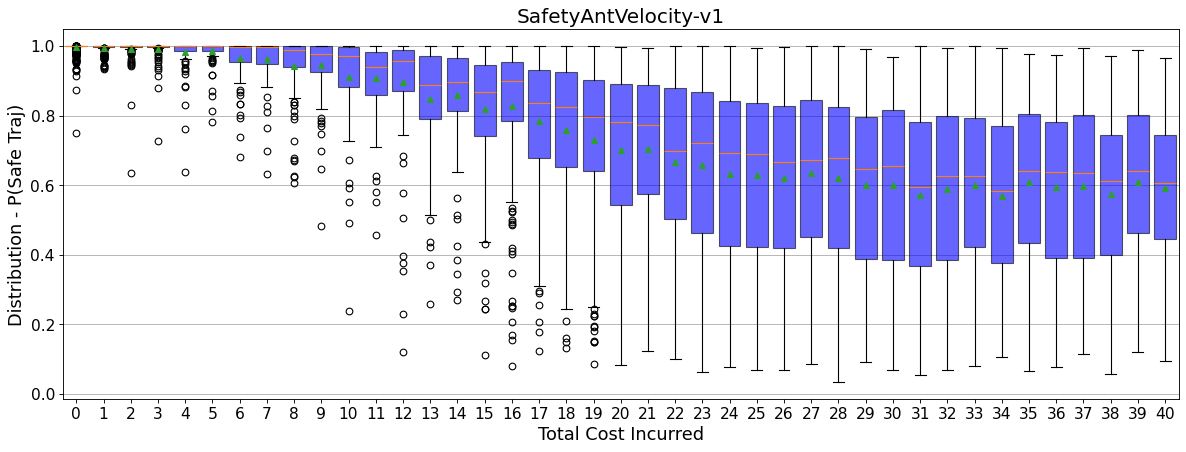

In [22]:
plot_traj_logscore_dist(dict_traj_ant, 'SafetyAntVelocity-v1')

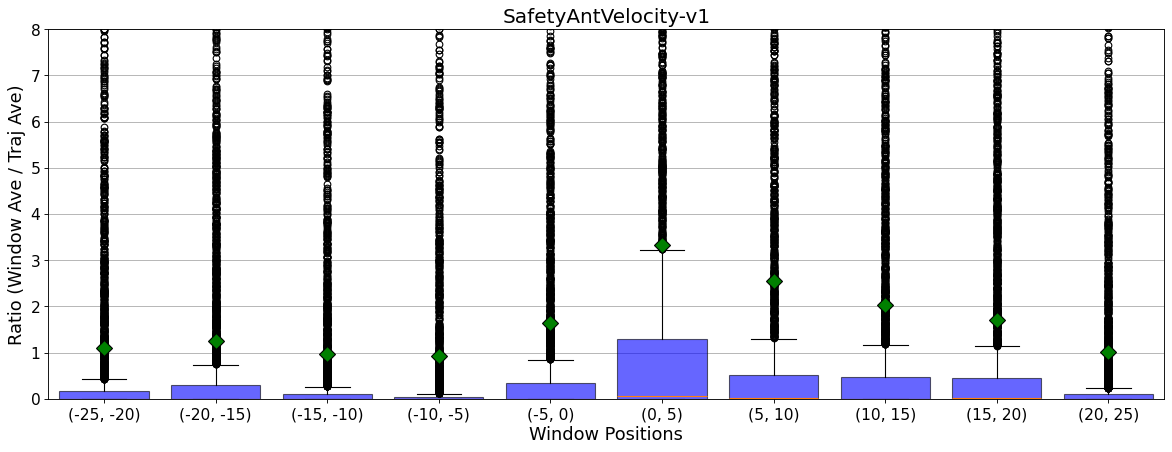

In [23]:
plot_ratio_window_logscore(dict_traj_ant, 'SafetyAntVelocity-v1')

In [24]:
ant_flat_logscore_ratio = calc_flat_ratio(dict_traj_ant, min_cum_c=50, buffer_space=20, min_flat_length=100)
np.mean(ant_flat_logscore_ratio)

0.2438545751436177

## HalfCheetah Domain

In [25]:
base_path_halfcheetah = '/SSD2/siowmeng/icml25_results/save_traj/exp-x/PPOLagLearnedH_0-0_SafetyHalfCheetahVelocity-v1/SafetyHalfCheetahVelocity-v1---762d923e857596b28a1951477403d8b0b9619a04856ea1d62498a5f17b40ded7/PPOLagLearnedH-{SafetyHalfCheetahVelocity-v1}/seed-000-2025-02-06-12-46-12'
dict_traj_halfcheetah= split_traj_dict(base_path_halfcheetah)

Processing file 0 out of 4482 files
Processing file 1000 out of 4482 files
Processing file 2000 out of 4482 files
Processing file 3000 out of 4482 files
Processing file 4000 out of 4482 files
Processing file 0 out of 5518 files
Processing file 1000 out of 5518 files
Processing file 2000 out of 5518 files
Processing file 3000 out of 5518 files
Processing file 4000 out of 5518 files
Processing file 5000 out of 5518 files


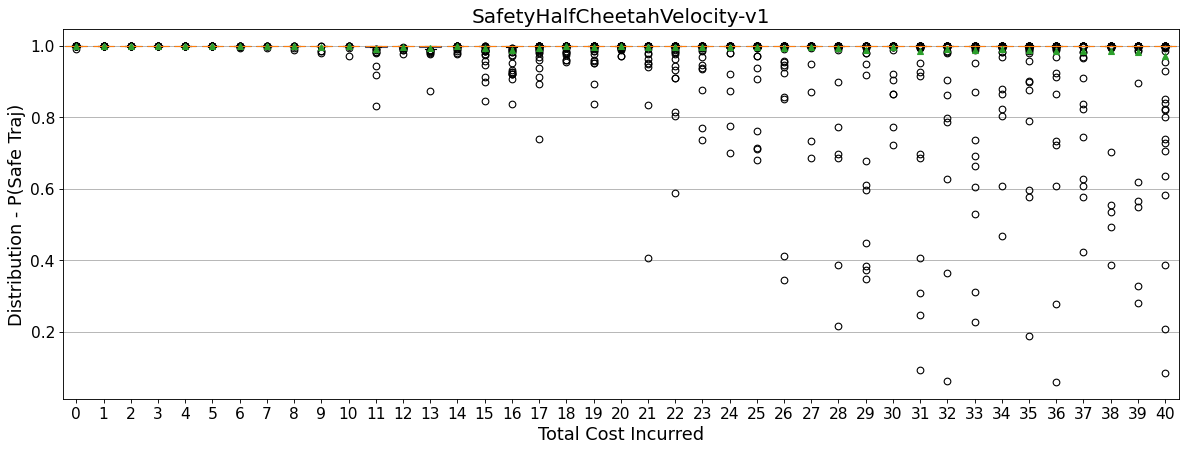

In [26]:
plot_traj_logscore_dist(dict_traj_halfcheetah, 'SafetyHalfCheetahVelocity-v1')

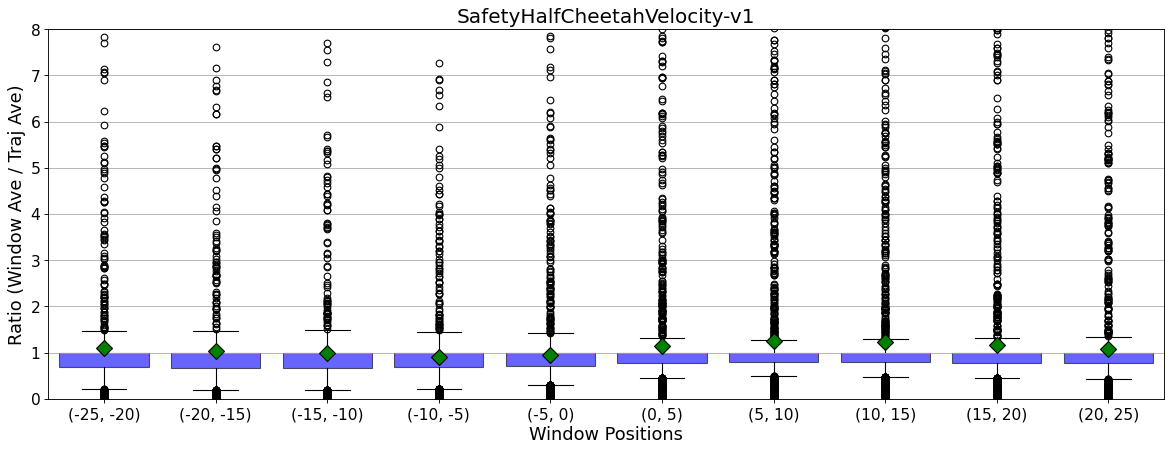

In [27]:
plot_ratio_window_logscore(dict_traj_halfcheetah, 'SafetyHalfCheetahVelocity-v1')

In [28]:
halfcheetah_flat_logscore_ratio = calc_flat_ratio(dict_traj_halfcheetah, min_cum_c=50, buffer_space=20, min_flat_length=100)
np.mean(halfcheetah_flat_logscore_ratio)

0.6600923541393626

## Hopper Domain

In [29]:
base_path_hopper = '/SSD2/siowmeng/icml25_results/save_traj/exp-x/PPOLagLearnedH_0-0_SafetyHopperVelocity-v1/SafetyHopperVelocity-v1---1509a139d3cb4f623f96830e689d9d0f9287363faa4fd8e2d8d088fe269c36f4/PPOLagLearnedH-{SafetyHopperVelocity-v1}/seed-000-2025-02-06-10-23-39'
dict_traj_hopper= split_traj_dict(base_path_hopper)

Processing file 0 out of 2779 files
Processing file 1000 out of 2779 files
Processing file 2000 out of 2779 files
Processing file 0 out of 7221 files
Processing file 1000 out of 7221 files
Processing file 2000 out of 7221 files
Processing file 3000 out of 7221 files
Processing file 4000 out of 7221 files
Processing file 5000 out of 7221 files
Processing file 6000 out of 7221 files
Processing file 7000 out of 7221 files


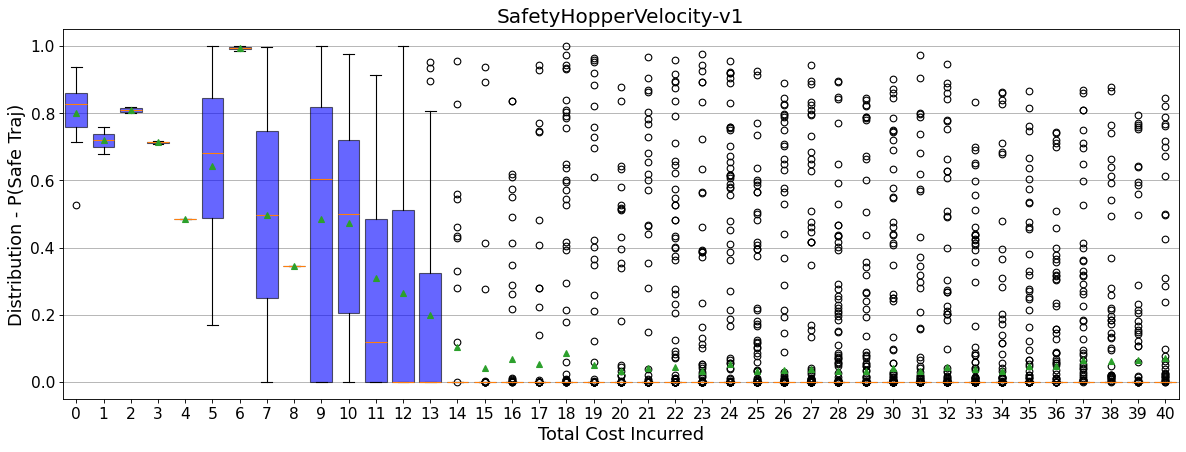

In [30]:
plot_traj_logscore_dist(dict_traj_hopper, 'SafetyHopperVelocity-v1')

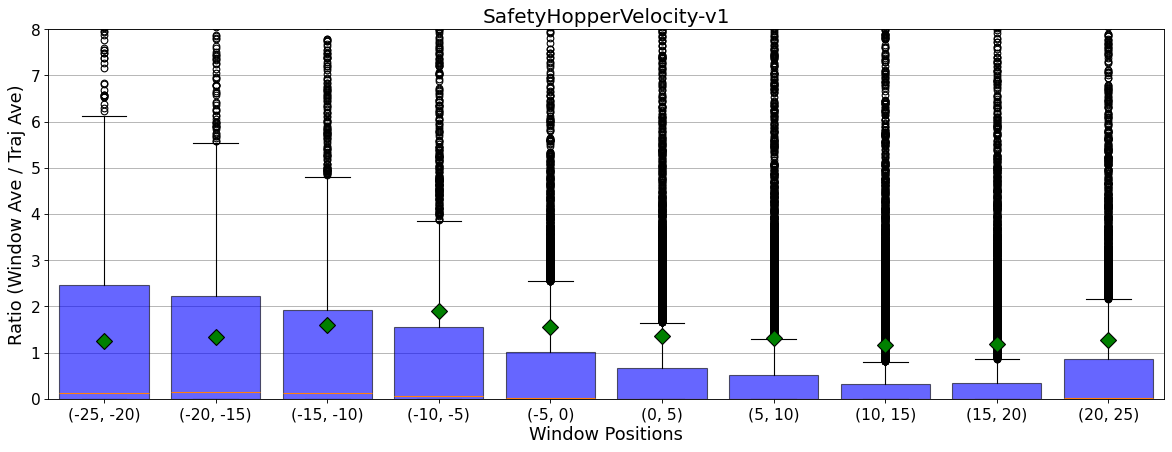

In [31]:
plot_ratio_window_logscore(dict_traj_hopper, 'SafetyHopperVelocity-v1')

In [32]:
hopper_flat_logscore_ratio = calc_flat_ratio(dict_traj_hopper, min_cum_c=50, buffer_space=20, min_flat_length=100)
np.mean(hopper_flat_logscore_ratio)

0.5375357996390422

## Walker2d Domain

In [6]:
base_path_walker = '/SSD2/siowmeng/icml25_results/save_traj/exp-x/PPOLagLearnedH_0-0_SafetyWalker2dVelocity-v1/SafetyWalker2dVelocity-v1---40b5aabac7ef01247fc323fdf12bce659e6276890806d89c8798132ca9825063/PPOLagLearnedH-{SafetyWalker2dVelocity-v1}/seed-000-2025-02-06-16-37-49'
dict_traj_walker = split_traj_dict(base_path_walker)

Processing file 0 out of 4457 files
Processing file 1000 out of 4457 files
Processing file 2000 out of 4457 files
Processing file 3000 out of 4457 files
Processing file 4000 out of 4457 files
Processing file 0 out of 5543 files
Processing file 1000 out of 5543 files
Processing file 2000 out of 5543 files
Processing file 3000 out of 5543 files
Processing file 4000 out of 5543 files
Processing file 5000 out of 5543 files


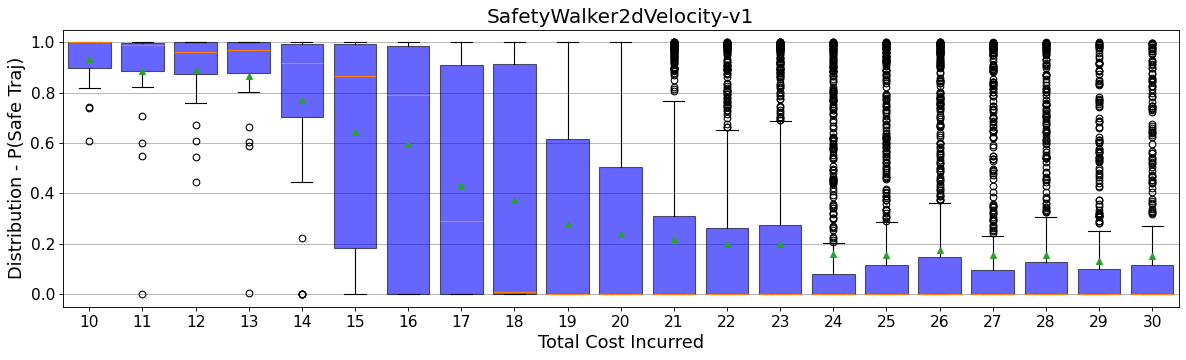

In [9]:
plot_traj_logscore_dist(dict_traj_walker, 'SafetyWalker2dVelocity-v1', 10, 31)

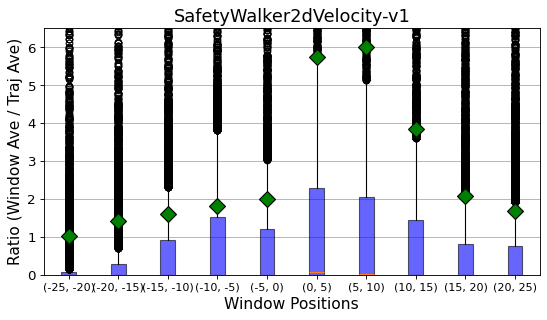

In [110]:
plot_ratio_window_logscore(dict_traj_walker, 'SafetyWalker2dVelocity-v1')

In [36]:
walker_flat_logscore_ratio = calc_flat_ratio(dict_traj_walker, min_cum_c=50, buffer_space=20, min_flat_length=100)
np.mean(walker_flat_logscore_ratio)

0.12378468395268305

## PointCircle1 Domain

In [37]:
base_path_pointcircle1 = '/SSD2/siowmeng/icml25_results/save_traj/exp-x/PPOLagLearnedH_0-0_SafetyPointCircle1-v0/SafetyPointCircle1-v0---4d6ba9f190ec1ba15e0fa5c9f3400dc3d9d0d36792200b20bc77212cb451c6ab/PPOLagLearnedH-{SafetyPointCircle1-v0}/seed-000-2025-02-06-13-30-22'
dict_traj_pointcircle1 = split_traj_dict(base_path_pointcircle1)

Processing file 0 out of 11581 files
Processing file 1000 out of 11581 files
Processing file 2000 out of 11581 files
Processing file 3000 out of 11581 files
Processing file 4000 out of 11581 files
Processing file 5000 out of 11581 files
Processing file 6000 out of 11581 files
Processing file 7000 out of 11581 files
Processing file 8000 out of 11581 files
Processing file 9000 out of 11581 files
Processing file 10000 out of 11581 files
Processing file 11000 out of 11581 files
Processing file 0 out of 8419 files
Processing file 1000 out of 8419 files
Processing file 2000 out of 8419 files
Processing file 3000 out of 8419 files
Processing file 4000 out of 8419 files
Processing file 5000 out of 8419 files
Processing file 6000 out of 8419 files
Processing file 7000 out of 8419 files
Processing file 8000 out of 8419 files


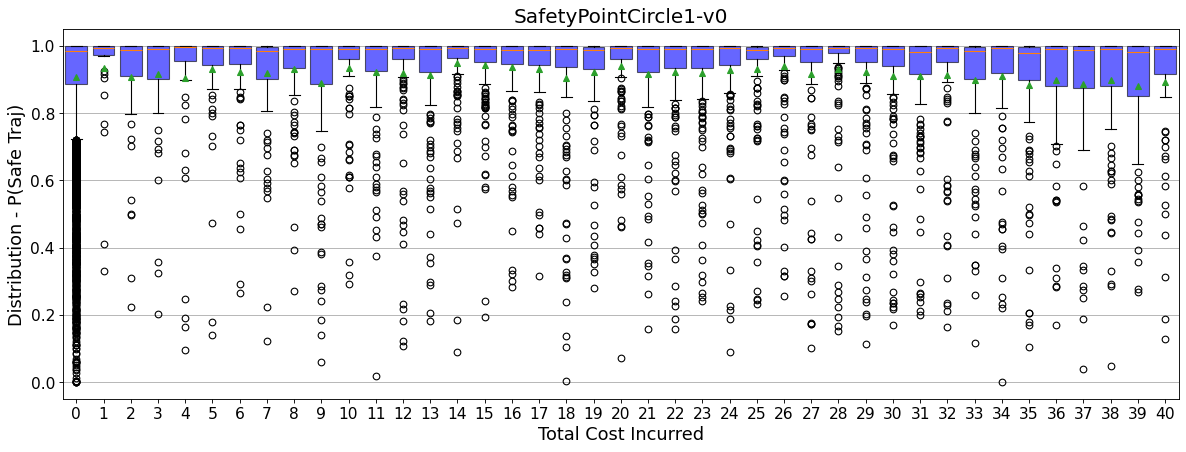

In [38]:
plot_traj_logscore_dist(dict_traj_pointcircle1, 'SafetyPointCircle1-v0')

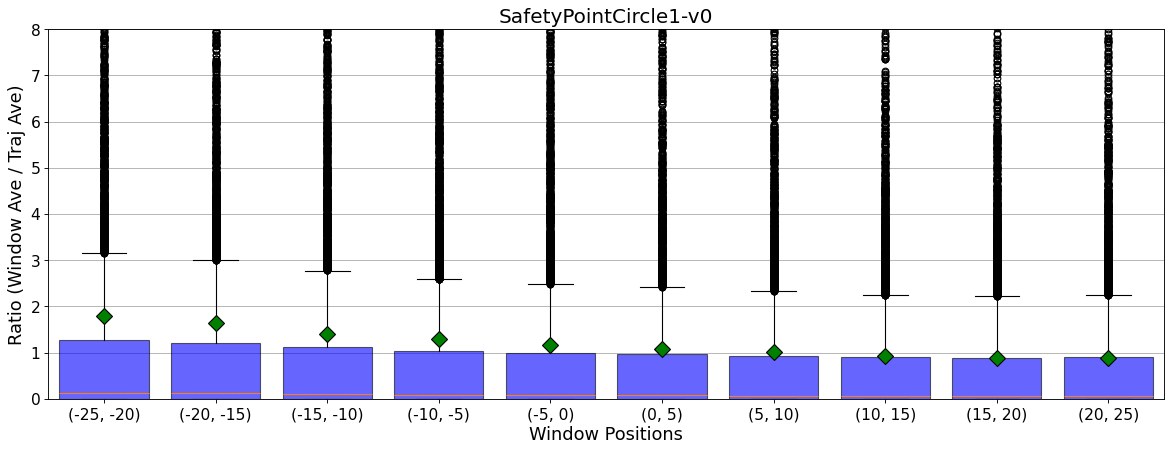

In [39]:
plot_ratio_window_logscore(dict_traj_pointcircle1, 'SafetyPointCircle1-v0')

In [40]:
pointcircle1_flat_logscore_ratio = calc_flat_ratio(dict_traj_pointcircle1, min_cum_c=50, buffer_space=20, min_flat_length=100)
np.mean(pointcircle1_flat_logscore_ratio)

0.9688101941104454

## PointCircle2 Domain

In [41]:
base_path_pointcircle2 = '/SSD2/siowmeng/icml25_results/save_traj/exp-x/PPOLagLearnedH_0-0_SafetyPointCircle2-v0/SafetyPointCircle2-v0---c4bc4f1e38e4467717dc275c5f603a1ab030e9c679b97a0e9f2028856814ec4c/PPOLagLearnedH-{SafetyPointCircle2-v0}/seed-000-2025-02-06-13-30-21'
dict_traj_pointcircle2 = split_traj_dict(base_path_pointcircle2)

Processing file 0 out of 10072 files
Processing file 1000 out of 10072 files
Processing file 2000 out of 10072 files
Processing file 3000 out of 10072 files
Processing file 4000 out of 10072 files
Processing file 5000 out of 10072 files
Processing file 6000 out of 10072 files
Processing file 7000 out of 10072 files
Processing file 8000 out of 10072 files
Processing file 9000 out of 10072 files
Processing file 10000 out of 10072 files
Processing file 0 out of 9928 files
Processing file 1000 out of 9928 files
Processing file 2000 out of 9928 files
Processing file 3000 out of 9928 files
Processing file 4000 out of 9928 files
Processing file 5000 out of 9928 files
Processing file 6000 out of 9928 files
Processing file 7000 out of 9928 files
Processing file 8000 out of 9928 files
Processing file 9000 out of 9928 files


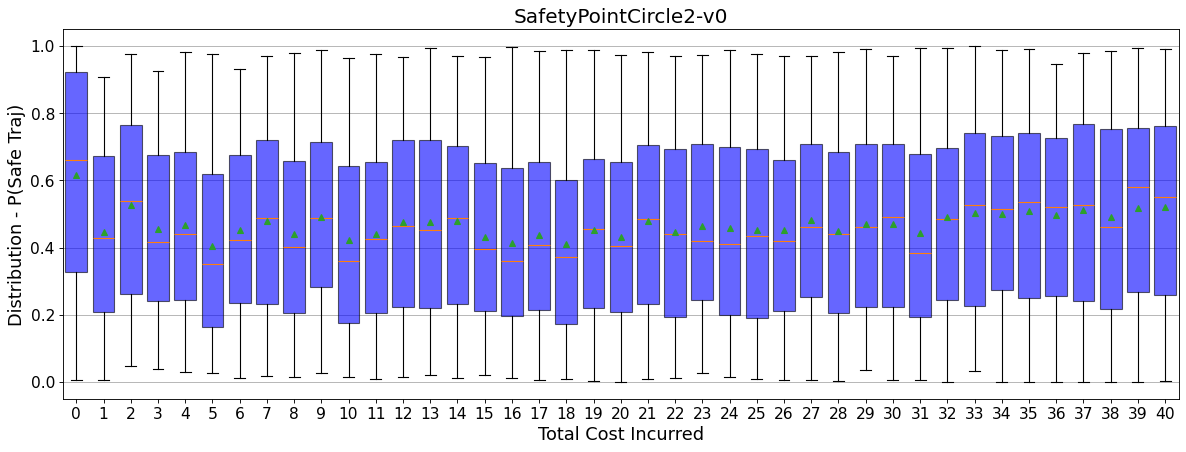

In [42]:
plot_traj_logscore_dist(dict_traj_pointcircle2, 'SafetyPointCircle2-v0')

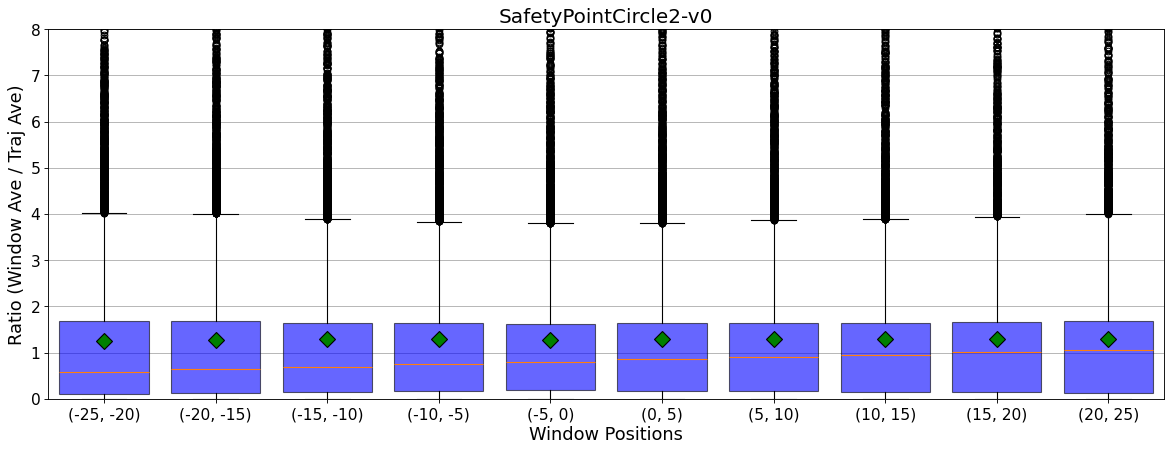

In [43]:
plot_ratio_window_logscore(dict_traj_pointcircle2, 'SafetyPointCircle2-v0')

In [44]:
pointcircle2_flat_logscore_ratio = calc_flat_ratio(dict_traj_pointcircle2, min_cum_c=50, buffer_space=20, min_flat_length=100)
np.mean(pointcircle2_flat_logscore_ratio)

0.45368587437126645

## CarCircle1 Domain

In [45]:
base_path_carcircle1 = '/SSD2/siowmeng/icml25_results/save_traj/exp-x/PPOLagLearnedH_0-0_SafetyCarCircle1-v0/SafetyCarCircle1-v0---4ba2d9e70de0e7896d4c958abe54ad44f0c3adf91b1477fcd228d94d82d2330c/PPOLagLearnedH-{SafetyCarCircle1-v0}/seed-000-2025-02-06-14-04-22'
dict_traj_carcircle1 = split_traj_dict(base_path_carcircle1)

Processing file 0 out of 13400 files
Processing file 1000 out of 13400 files
Processing file 2000 out of 13400 files
Processing file 3000 out of 13400 files
Processing file 4000 out of 13400 files
Processing file 5000 out of 13400 files
Processing file 6000 out of 13400 files
Processing file 7000 out of 13400 files
Processing file 8000 out of 13400 files
Processing file 9000 out of 13400 files
Processing file 10000 out of 13400 files
Processing file 11000 out of 13400 files
Processing file 12000 out of 13400 files
Processing file 13000 out of 13400 files
Processing file 0 out of 6600 files
Processing file 1000 out of 6600 files
Processing file 2000 out of 6600 files
Processing file 3000 out of 6600 files
Processing file 4000 out of 6600 files
Processing file 5000 out of 6600 files
Processing file 6000 out of 6600 files


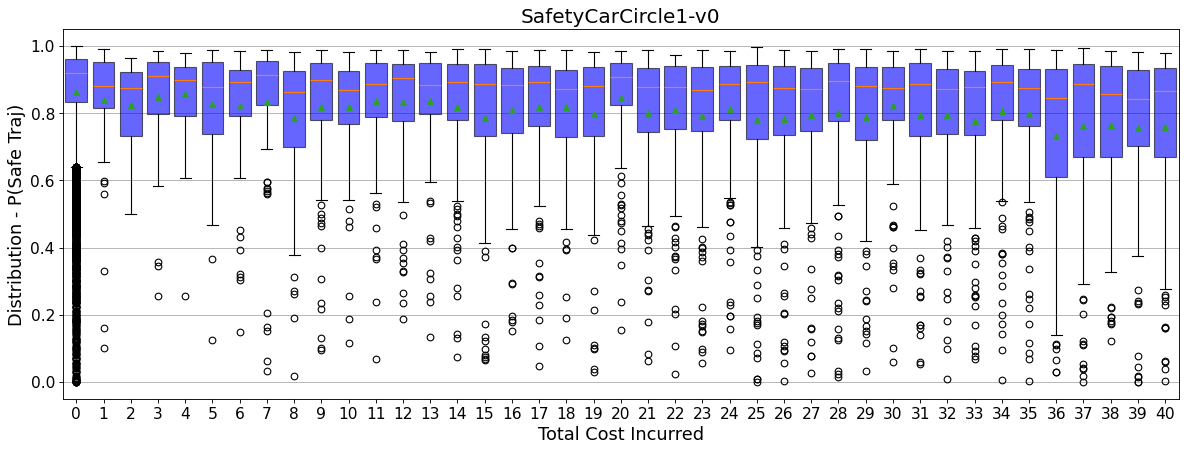

In [46]:
plot_traj_logscore_dist(dict_traj_carcircle1, 'SafetyCarCircle1-v0')

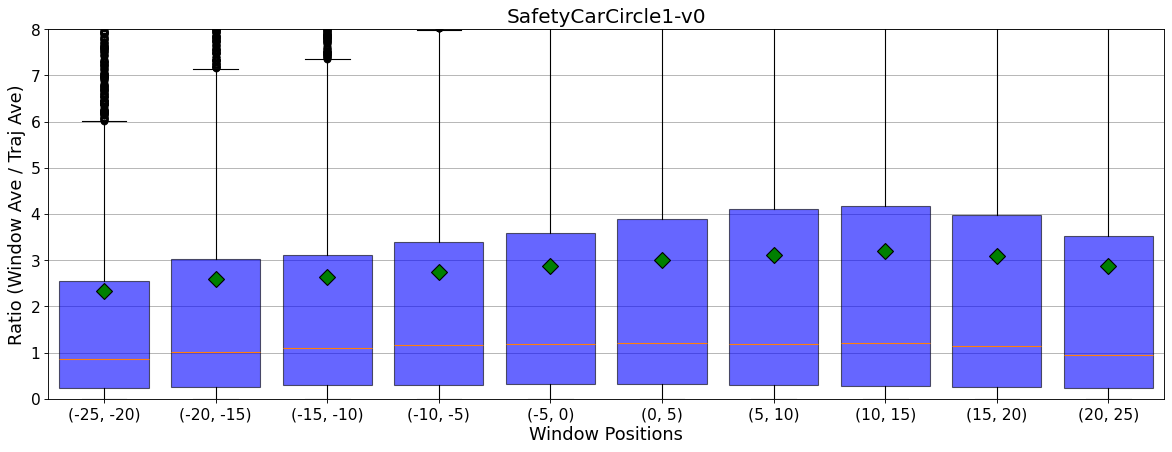

In [47]:
plot_ratio_window_logscore(dict_traj_carcircle1, 'SafetyCarCircle1-v0')

In [48]:
carcircle1_flat_logscore_ratio = calc_flat_ratio(dict_traj_carcircle1, min_cum_c=50, buffer_space=20, min_flat_length=100)
np.mean(carcircle1_flat_logscore_ratio)

0.47468575604322777

## CarCircle2 Domain

In [49]:
base_path_carcircle2 = '/SSD2/siowmeng/icml25_results/save_traj/exp-x/PPOLagLearnedH_0-0_SafetyCarCircle2-v0/SafetyCarCircle2-v0---cc422b1710323180c0538fa59f976c17ef9983ed3f722791683706485ff7ec16/PPOLagLearnedH-{SafetyCarCircle2-v0}/seed-000-2025-02-06-13-32-45'
dict_traj_carcircle2 = split_traj_dict(base_path_carcircle2)

Processing file 0 out of 14714 files
Processing file 1000 out of 14714 files
Processing file 2000 out of 14714 files
Processing file 3000 out of 14714 files
Processing file 4000 out of 14714 files
Processing file 5000 out of 14714 files
Processing file 6000 out of 14714 files
Processing file 7000 out of 14714 files
Processing file 8000 out of 14714 files
Processing file 9000 out of 14714 files
Processing file 10000 out of 14714 files
Processing file 11000 out of 14714 files
Processing file 12000 out of 14714 files
Processing file 13000 out of 14714 files
Processing file 14000 out of 14714 files
Processing file 0 out of 5286 files
Processing file 1000 out of 5286 files
Processing file 2000 out of 5286 files
Processing file 3000 out of 5286 files
Processing file 4000 out of 5286 files
Processing file 5000 out of 5286 files


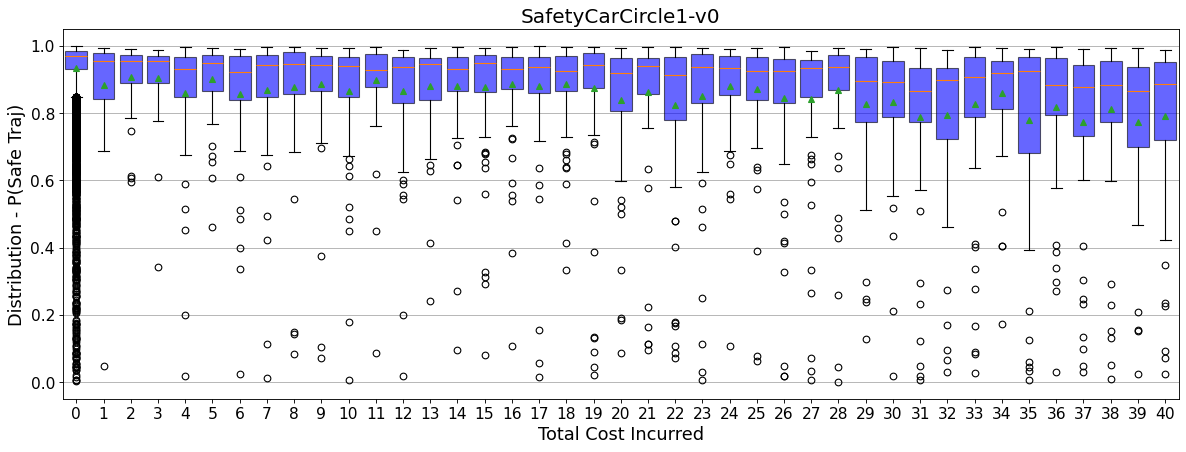

In [50]:
plot_traj_logscore_dist(dict_traj_carcircle2, 'SafetyCarCircle1-v0')

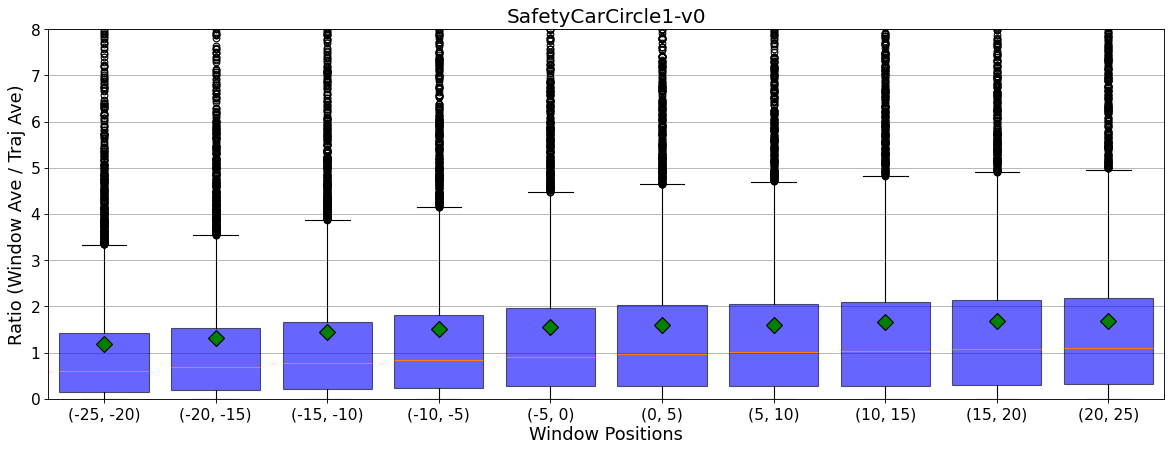

In [51]:
plot_ratio_window_logscore(dict_traj_carcircle2, 'SafetyCarCircle1-v0')

In [52]:
carcircle2_flat_logscore_ratio = calc_flat_ratio(dict_traj_carcircle2, min_cum_c=50, buffer_space=20, min_flat_length=100)
np.mean(carcircle2_flat_logscore_ratio)

0.5576032813381276

## AntRun Domain

In [53]:
base_path_antrun = '/SSD2/siowmeng/icml25_results/save_traj/exp-x/PPOLagLearnedH_0-0_SafetyAntRun-v0/SafetyAntRun-v0---dff84b103d727b389e800b842a632d3bbd024592827184d5894bdb95eb3a8687/PPOLagLearnedH-{SafetyAntRun-v0}/seed-000-2025-02-06-16-32-41'
dict_traj_antrun = split_traj_dict(base_path_antrun)

Processing file 0 out of 8368 files
Processing file 1000 out of 8368 files
Processing file 2000 out of 8368 files
Processing file 3000 out of 8368 files
Processing file 4000 out of 8368 files
Processing file 5000 out of 8368 files
Processing file 6000 out of 8368 files
Processing file 7000 out of 8368 files
Processing file 8000 out of 8368 files
Processing file 0 out of 1647 files
Processing file 1000 out of 1647 files


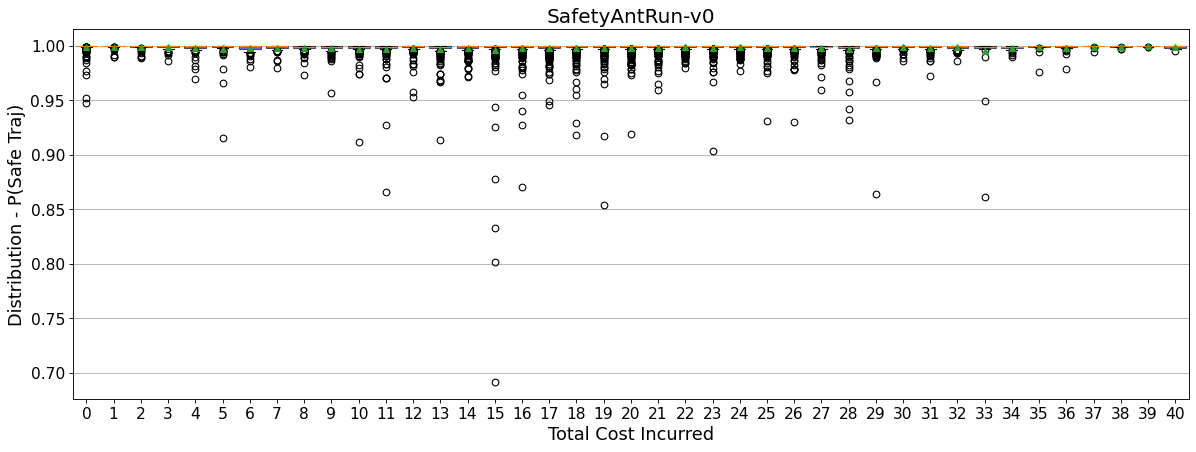

In [54]:
plot_traj_logscore_dist(dict_traj_antrun, 'SafetyAntRun-v0')

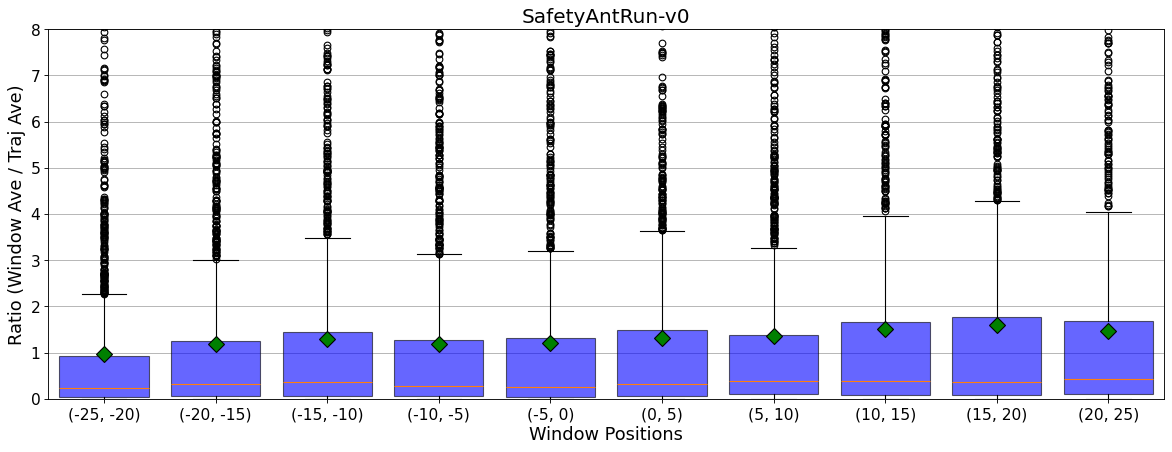

In [55]:
plot_ratio_window_logscore(dict_traj_antrun, 'SafetyAntRun-v0')

In [56]:
antrun_flat_logscore_ratio = calc_flat_ratio(dict_traj_antrun, min_cum_c=50, buffer_space=5, min_flat_length=40)
np.mean(antrun_flat_logscore_ratio)

0.9612773547518458

## BallRun Domain

In [12]:
base_path_ballrun = '/SSD2/siowmeng/icml25_results/save_traj/exp-x/PPOLagLearnedH_0-0_SafetyBallRun-v0/SafetyBallRun-v0---3891af7cacc89150a4edab329d17298b57f9a5495a8fe5eea7afe4705d047785/PPOLagLearnedH-{SafetyBallRun-v0}/seed-000-2025-02-06-16-32-37'
dict_traj_ballrun = split_traj_dict(base_path_ballrun)

Processing file 0 out of 4484 files
Processing file 1000 out of 4484 files
Processing file 2000 out of 4484 files
Processing file 3000 out of 4484 files
Processing file 4000 out of 4484 files
Processing file 0 out of 5516 files
Processing file 1000 out of 5516 files
Processing file 2000 out of 5516 files
Processing file 3000 out of 5516 files
Processing file 4000 out of 5516 files
Processing file 5000 out of 5516 files


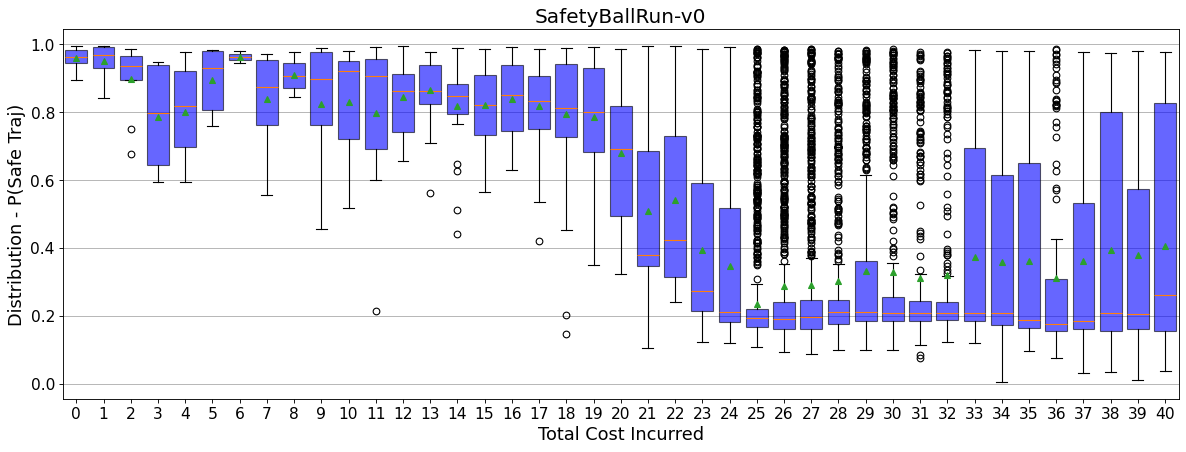

In [58]:
plot_traj_logscore_dist(dict_traj_ballrun, 'SafetyBallRun-v0')

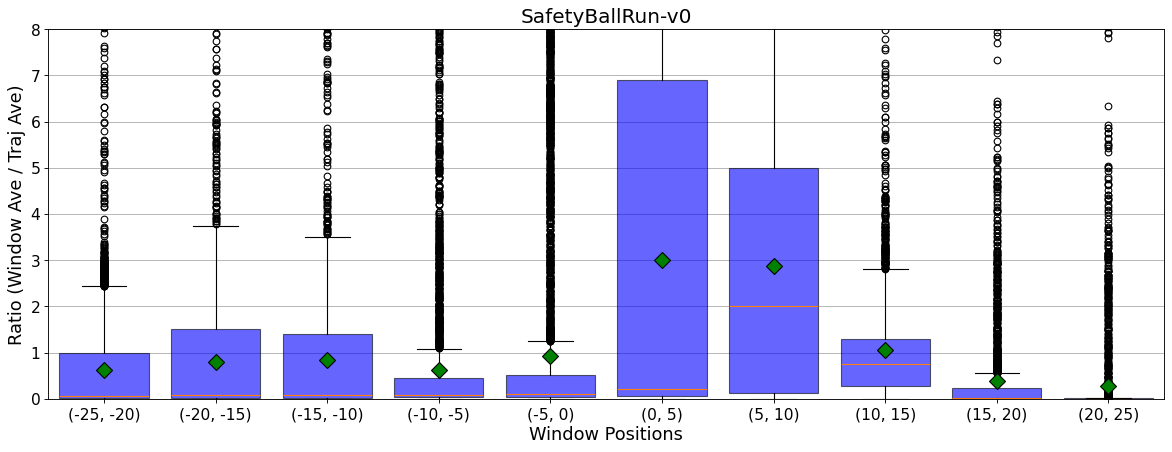

In [59]:
plot_ratio_window_logscore(dict_traj_ballrun, 'SafetyBallRun-v0')

In [60]:
ballrun_flat_logscore_ratio = calc_flat_ratio(dict_traj_ballrun, min_cum_c=50, buffer_space=5, min_flat_length=40)
np.mean(ballrun_flat_logscore_ratio)

0.05861622036383387

## CarRun Domain

In [13]:
base_path_carrun = '/SSD2/siowmeng/icml25_results/save_traj/exp-x/PPOLagLearnedH_0-0_SafetyCarRun-v0/SafetyCarRun-v0---4d1aa4421b9ca190ac6de7e30535227a39b0f3bfd3c86819ef6db68ca5944ab6/PPOLagLearnedH-{SafetyCarRun-v0}/seed-000-2025-02-06-16-32-37'
dict_traj_carrun = split_traj_dict(base_path_carrun)

Processing file 0 out of 8217 files
Processing file 1000 out of 8217 files
Processing file 2000 out of 8217 files
Processing file 3000 out of 8217 files
Processing file 4000 out of 8217 files
Processing file 5000 out of 8217 files
Processing file 6000 out of 8217 files
Processing file 7000 out of 8217 files
Processing file 8000 out of 8217 files
Processing file 0 out of 1783 files
Processing file 1000 out of 1783 files


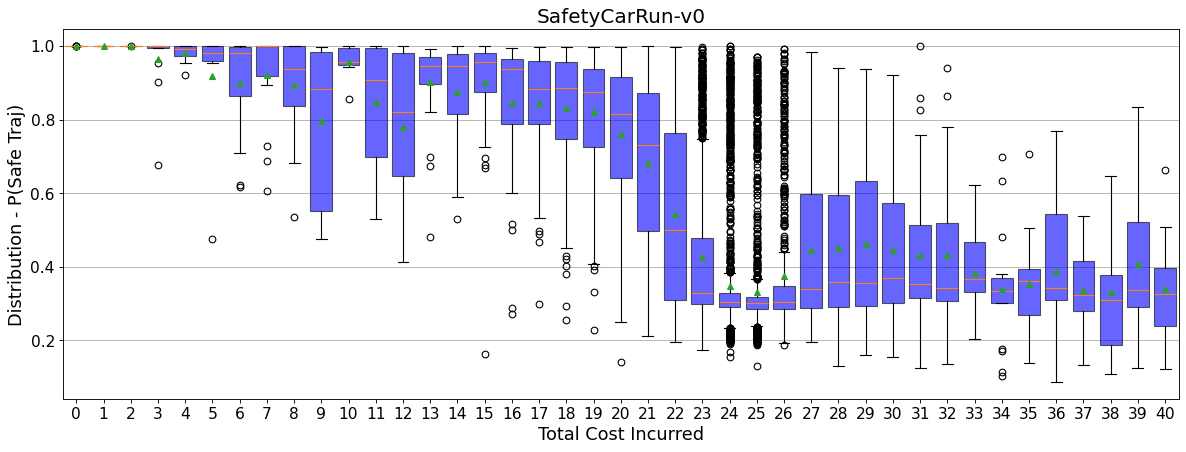

In [62]:
plot_traj_logscore_dist(dict_traj_carrun, 'SafetyCarRun-v0')

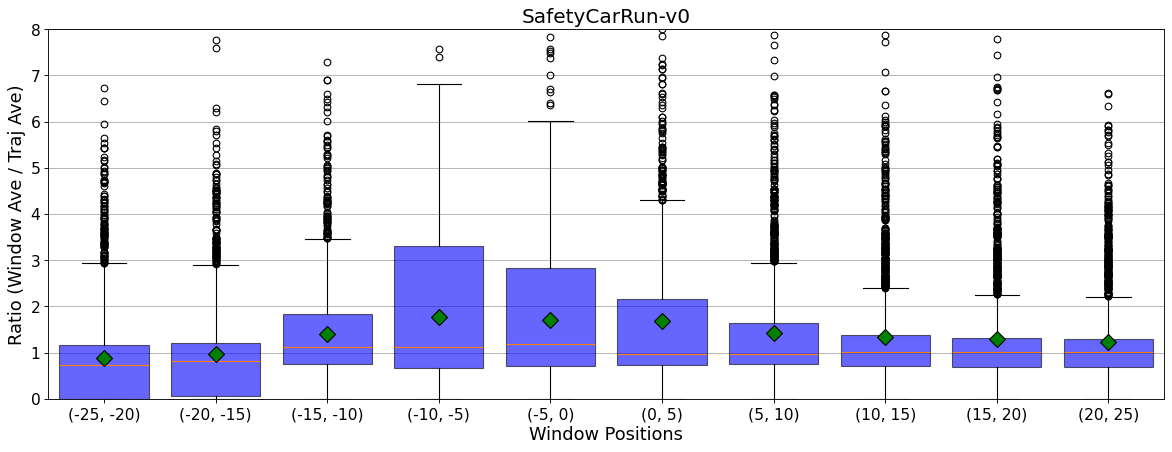

In [63]:
plot_ratio_window_logscore(dict_traj_carrun, 'SafetyCarRun-v0')

In [64]:
carrun_flat_logscore_ratio = calc_flat_ratio(dict_traj_carrun, min_cum_c=50, buffer_space=5, min_flat_length=40)
np.mean(carrun_flat_logscore_ratio)

0.06346595383957454

## DroneRun Domain

In [65]:
base_path_dronerun = '/SSD2/siowmeng/icml25_results/save_traj/exp-x/PPOLagLearnedH_0-0_SafetyDroneRun-v0/SafetyDroneRun-v0---d9a23cbdd57f4b79355398717dd7b0c01eed42bb0146972abee619dd472aff8d/PPOLagLearnedH-{SafetyDroneRun-v0}/seed-000-2025-02-06-16-32-41'
dict_traj_dronerun = split_traj_dict(base_path_dronerun)

Processing file 0 out of 6858 files
Processing file 1000 out of 6858 files
Processing file 2000 out of 6858 files
Processing file 3000 out of 6858 files
Processing file 4000 out of 6858 files
Processing file 5000 out of 6858 files
Processing file 6000 out of 6858 files
Processing file 0 out of 3157 files
Processing file 1000 out of 3157 files
Processing file 2000 out of 3157 files
Processing file 3000 out of 3157 files


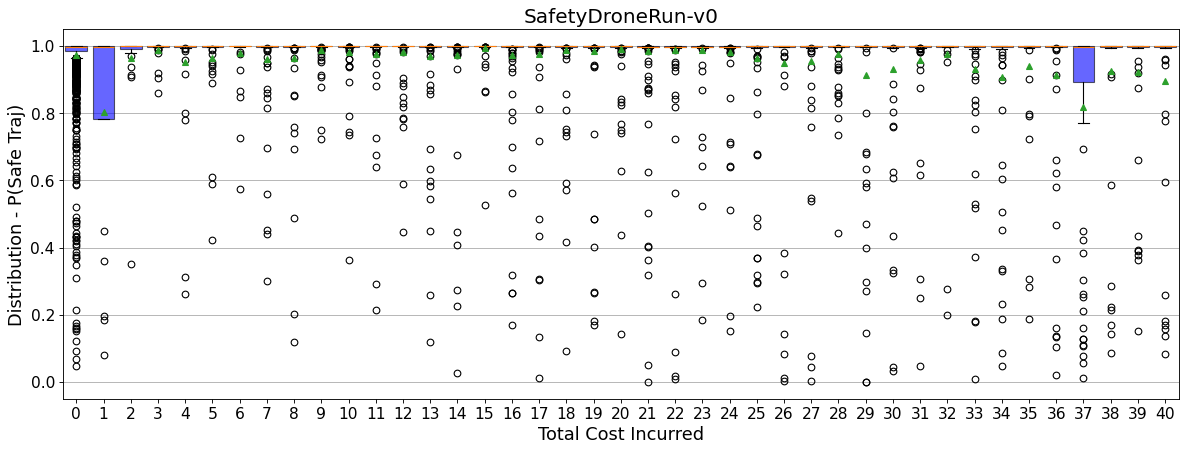

In [66]:
plot_traj_logscore_dist(dict_traj_dronerun, 'SafetyDroneRun-v0')

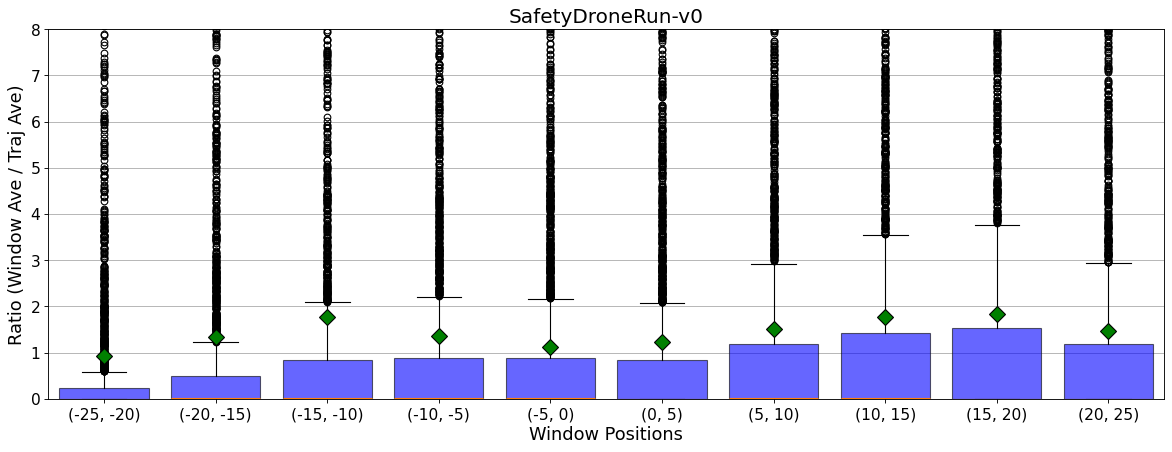

In [67]:
plot_ratio_window_logscore(dict_traj_dronerun, 'SafetyDroneRun-v0')

In [68]:
dronerun_flat_logscore_ratio = calc_flat_ratio(dict_traj_dronerun, min_cum_c=50, buffer_space=5, min_flat_length=40)
np.mean(dronerun_flat_logscore_ratio)

0.7219597913741497

## Flat Region

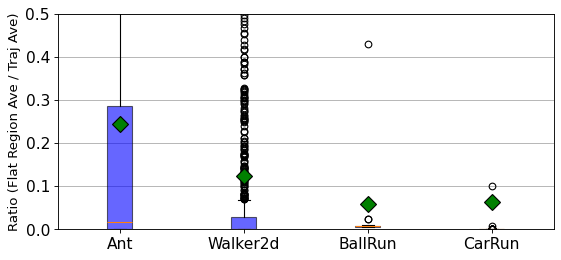

In [111]:
figure(figsize=(8, 3.5), dpi=80)
    
plot_data = [ant_flat_logscore_ratio, 
             #hopper_flat_logscore_ratio, 
             walker_flat_logscore_ratio, 
             ballrun_flat_logscore_ratio, 
             carrun_flat_logscore_ratio]
plot_x = ['Ant', #'Hopper', 
          'Walker2d', 'BallRun', 'CarRun']

# Customization for the mean marker
meanprops = {
    "marker": "D",           # Diamond shape
    "markerfacecolor": "green", # Red color
    "markeredgecolor": "black",
    "markersize": 10          # Larger size
}

# Create the boxplots
plt.boxplot(plot_data, positions=list(range(len(plot_x))), widths=0.2, patch_artist=True,
            boxprops=dict(facecolor='blue', alpha=0.6), tick_labels=plot_x, showmeans=True, meanprops=meanprops)

#Customize x-axis positions
#plt.xticks([(pos1 + pos2) / 2 for pos1, pos2 in zip(positions1, positions2)], x_labels)

# Add grid and labels
# plt.title(domain)
plt.ylabel('Ratio (Flat Region Ave / Traj Ave)', fontsize=12)
plt.xticks(fontsize=14)  # X-axis tick font size
plt.yticks(fontsize=14)  # Y-axis tick font size
# plt.xlabel('Total Cost Incurred')
plt.grid(axis='y')

plt.ylim(0, 0.5)

# Show the plot
# plt.legend()
plt.savefig('flat_region_distribution.pdf')

plt.show()

## Individual Chart

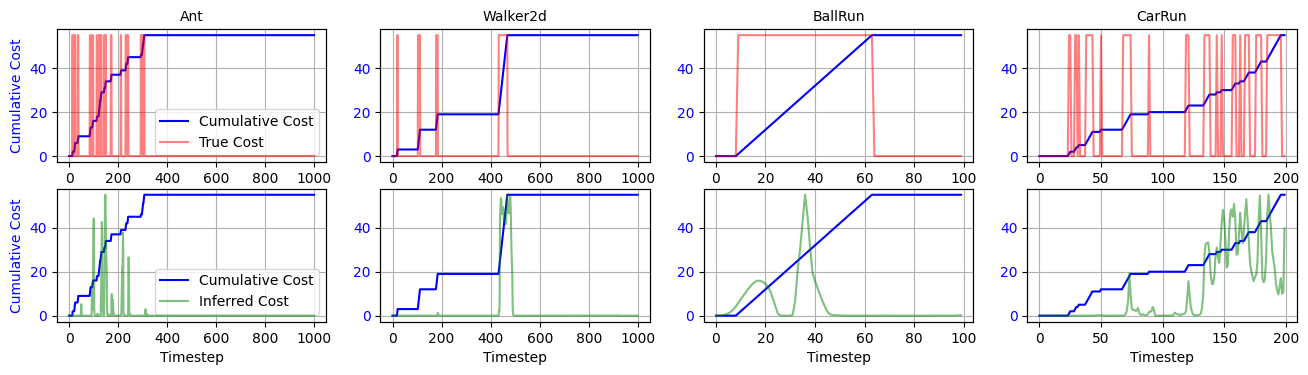

In [25]:
plot_dicts = [dict_traj_ant, dict_traj_walker, dict_traj_ballrun, dict_traj_carrun]
plot_title = ['Ant', 'Walker2d', 'BallRun', 'CarRun']

plt.style.use('default')
# fig, axs = plt.subplots(2, len(plot_dicts), figsize=(len(plot_dicts) * 4, 2 * 2.5))
fig, axs = plt.subplots(2, len(plot_dicts), figsize=(len(plot_dicts) * 4, 2 * 1.9))
fontsize = 10

for i, p_dict in enumerate(plot_dicts):
    
    plotDF = p_dict[55][-1][['c', 'cum_c', 'new_logscore_mean']]
    x = list(range(plotDF.shape[0]))    
    
    cum_c_line, = axs[0, i].plot(x, plotDF['cum_c'].to_numpy(), color='blue', label='Cumulative Cost')
    
    if i == 0:
        axs[0, i].set_ylabel('Cumulative Cost', color='blue')
    axs[0, i].tick_params(axis='y', labelcolor='blue')
    axs[0, i].grid(True)
    axs[0, i].set_title(plot_title[i], fontsize = fontsize)
    
    # Create a secondary y-axis
    ax2 = axs[0, i].twinx()
    c_line, = ax2.plot(x, plotDF['c'].to_numpy(), color='red', label='True Cost', alpha = 0.5)
    #ax2.plot(x, y_norm_logscores, color='orange', label='Normalized Logscores', alpha = 0.5)
    # ax2.set_ylabel('True Cost', color='red')
    # ax2.tick_params(axis='y', labelcolor='red')
    ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)

    cum_c_line2, = axs[1, i].plot(x, plotDF['cum_c'].to_numpy(), color='blue', label='Cumulative Cost')
    axs[1, i].set_xlabel('Timestep', fontsize = fontsize)
    if i == 0:
        axs[0, i].set_ylabel('Cumulative Cost', color='blue', fontsize = fontsize)
        axs[1, i].set_ylabel('Cumulative Cost', color='blue', fontsize = fontsize)
    axs[1, i].tick_params(axis='y', labelcolor='blue')
    axs[1, i].grid(True)
    
    ax22 = axs[1, i].twinx()
    c_line2, = ax22.plot(x, plotDF['new_logscore_mean'].to_numpy() / plotDF['new_logscore_mean'].min(), color='green', label='Inferred Cost', alpha = 0.5)
    #ax2.plot(x, y_norm_logscores, color='orange', label='Normalized Logscores', alpha = 0.5)
    # ax2.set_ylabel('True Cost', color='red')
    # ax2.tick_params(axis='y', labelcolor='red')
    ax22.tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)
    
    # Add a title
    #fig.suptitle('Two Time Series with Different Scales')
    
    # Combine legends
    lines = [cum_c_line, c_line]
    labels = [line.get_label() for line in lines]
    axs[0, 0].legend(lines, labels, loc='lower right')

    lines = [cum_c_line2, c_line2]
    labels = [line.get_label() for line in lines]
    axs[1, 0].legend(lines, labels, loc='lower right')
    
fig.savefig('individual_traj.pdf')

In [48]:
plotDF = unsafe_dfs[2000]
# Example time series data
x = list(range(1000))
y_cum_c = plotDF['cum_c'].to_numpy()
y_c = plotDF['c'].to_numpy()
y_norm_logscores = plotDF['new_logscore_mean'].to_numpy() / plotDF['new_logscore_mean'].min()

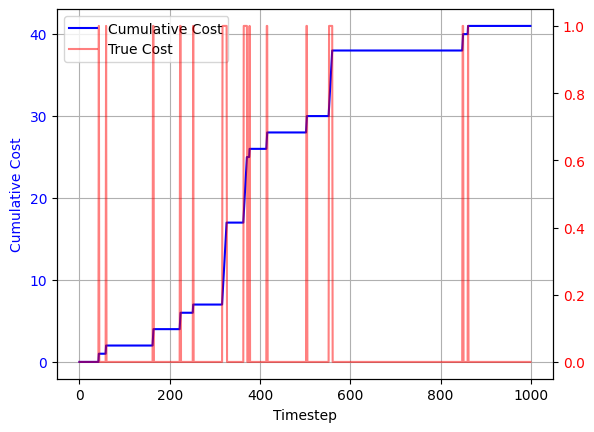

In [49]:
# Create the plot
fig, ax1 = plt.subplots()

# Plot the first time series
line1, = ax1.plot(x, y_cum_c, color='blue', label='Cumulative Cost')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Cumulative Cost', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a secondary y-axis
ax2 = ax1.twinx()
line2, = ax2.plot(x, y_c, color='red', label='True Cost', alpha = 0.5)
#ax2.plot(x, y_norm_logscores, color='orange', label='Normalized Logscores', alpha = 0.5)
ax2.set_ylabel('True Cost', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title
#fig.suptitle('Two Time Series with Different Scales')

# Combine legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Show the plot
plt.show()

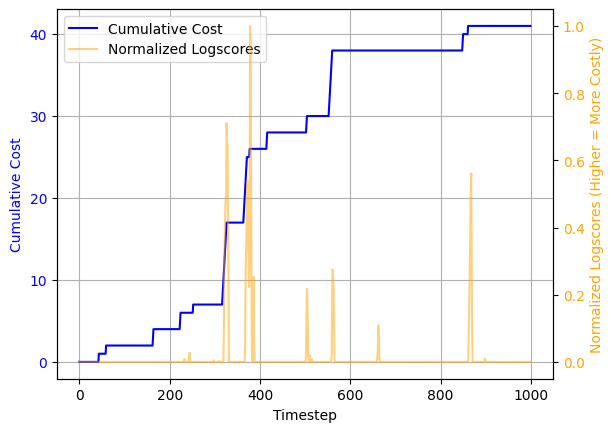

In [53]:
# Create the plot
fig, ax1 = plt.subplots()

# Plot the first time series
line1, = ax1.plot(x, y_cum_c, color='blue', label='Cumulative Cost')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Cumulative Cost', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Create a secondary y-axis
ax2 = ax1.twinx()
line2, = ax2.plot(x, y_norm_logscores, color='orange', label='Normalized Logscores', alpha = 0.5)
#ax2.plot(x, y_norm_logscores, color='orange', label='Normalized Logscores', alpha = 0.5)
ax2.set_ylabel('Normalized Logscores (Higher = More Costly)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a title
#fig.suptitle('Two Time Series with Different Scales')

# Combine legends
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper left')

# Show the plot
plt.show()

In [21]:
plotDF = unsafe_dfs[4]

1. Flat region with 100 timesteps, only inner 80%, computer average logscore
2. Near threshold (budget 25), 10 timestep bef & 10 timesteps aft
3. x-axis is timestep aft, y is the percentage of logscore (boxplots)

def calc_stats(basepath, safe = True):
    safe_stats = {}
    meanlogscores_stats = {}
    list_df = []
    list_flat_logscores = []
    all_logscores = []
    dict_prop_bef, dict_prop_aft = {}, {}
    bef_timesteps_tuple = [(-25, -20), (-20, -15), (-15, -10), (-10, -5), (-5, 0)]
    for timestep_tuple in bef_timesteps_tuple:
        dict_prop_bef[timestep_tuple] = []
    aft_timesteps_tuple = [(0, 5), (5, 10), (10, 15), (15, 20), (20, 25)]
    for timestep_tuple in aft_timesteps_tuple:
        dict_prop_aft[timestep_tuple] = []
    
    if safe:
        for i in range(0, 26):
            safe_stats[i] = []
            meanlogscores_stats[i] = []
        csv_path = os.path.join(basepath, 'enriched_trajs', 'safe')
    else:
        for i in range(0, 1000):
            safe_stats[i] = []
            if i > 25:
                meanlogscores_stats[i] = []
        csv_path = os.path.join(basepath, 'enriched_trajs', 'unsafe')
            
    csv_files = [f for f in os.listdir(csv_path) if os.path.isfile(os.path.join(csv_path, f))]

    for i, filename in enumerate(csv_files):
        if i % 1000 == 0:
            print("Processing file", i, "out of", len(csv_files), "files")
        df = pd.read_csv(os.path.join(csv_path, filename))
        total_logscores = df['new_logscore_mean'].sum()
        meanlogscores_stats[df['c'].sum().astype(int)].append(total_logscores)
        filtered_df = df[df.c > 0][['c', 'cum_c', 'new_logscore_mean']]
        filtered_idx = [0] + filtered_df.index.tolist()
        filtered_cum_c = [0] + filtered_df.cum_c.astype(int).tolist()

        for j in range(len(filtered_idx)):
            if j < len(filtered_idx) - 1:
                safe_stats[filtered_cum_c[j]].append(df[filtered_idx[j]:filtered_idx[j+1]]['new_logscore_mean'].sum() / total_logscores)
                len_flat_region = filtered_idx[j+1] - filtered_idx[j]
                #buffer_space = math.ceil(len_flat_region * 0.2)
                buffer_space = 20
                if len_flat_region >= 100:
                    list_flat_logscores.append(df[(filtered_idx[j]+buffer_space):(filtered_idx[j+1]-buffer_space)]['new_logscore_mean'].mean())
            else:                
                safe_stats[filtered_cum_c[j]].append(df[filtered_idx[j]:]['new_logscore_mean'].sum() / total_logscores)
                len_flat_region = df.shape[0] - filtered_idx[j]
                #buffer_space = math.ceil(len_flat_region * 0.2)
                buffer_space = 20
                if len_flat_region >= 100:.
                    list_flat_logscores.append(df[(filtered_idx[j]+buffer_space):]['new_logscore_mean'].mean())
            
        if df['new_logscore_mean'].sum() <= 0 and not safe:
            threshold_idx = df[(df['cum_c'] == 26) & (df['c'] == 1)].index[0]
            for timestep_bef_tuple in bef_timesteps_tuple:
                start_idx, end_idx = threshold_idx + timestep_bef_tuple[0], threshold_idx + timestep_bef_tuple[1]
                if start_idx >= 0 or end_idx > 0:
                    if start_idx < 0:
                        start_idx = 0
                    elif end_idx <= 0:
                        end_idx = 1
                        
                    dict_prop_bef[timestep_bef_tuple].append(df[start_idx:end_idx]['new_logscore_mean'].mean() / df['new_logscore_mean'].mean())
                    
            for timestep_aft_tuple in aft_timesteps_tuple:
                start_idx, end_idx = threshold_idx + timestep_aft_tuple[0], threshold_idx + timestep_aft_tuple[1]
                if start_idx < df.shape[0] or end_idx <= df.shape[0]:                    
                    if start_idx >= df.shape[0]:
                        start_idx = df.shape[0] - 1
                    elif end_idx > df.shape[0]:
                        end_idx = df.shape[0]
                    
                    dict_prop_aft[timestep_aft_tuple].append(df[start_idx:end_idx]['new_logscore_mean'].mean() / df['new_logscore_mean'].mean())
                    
        list_df.append(df)
        all_logscores += df['new_logscore_mean'].tolist()
        

    return safe_stats, meanlogscores_stats, list_df, list_flat_logscores, all_logscores, dict_prop_bef, dict_prop_aft#, c0_logscores, c1_logscores
        